## Задача 1

Реализовать класс для работы с линейной регрессией

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20, learning_rate=0.01, max_iter=1000, tol=1e-4):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")
        if regularization in ['l1', 'l1l2'] and weight_calc == 'matrix':
            raise ValueError("При 'l1' или 'l1l2' регуляризации нельзя использовать 'matrix' метод")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.coefs_ = None
        self.intercept_ = None
        self.scaler = StandardScaler()
        self.is_fitted = False

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        # Преобразуем в numpy массивы
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values.flatten()
        elif isinstance(y, pd.Series):
            y = y.values
        
        # Нормализация признаков
        X_scaled = self.scaler.fit_transform(X)
        
        # Добавляем столбец единиц для intercept
        X_with_intercept = np.column_stack([np.ones(X_scaled.shape[0]), X_scaled])
        
        n_features = X_scaled.shape[1]
        
        if self.weight_calc == 'matrix':
            # Матричный метод (только для L2 или без регуляризации)
            if self.regularization == 'l2' or self.regularization == 'l1l2':
                # Ridge: (X^T X + lambda*I)^(-1) X^T y
                reg_matrix = np.eye(n_features + 1)
                reg_matrix[0, 0] = 0  # Не регуляризуем intercept
                if self.regularization == 'l2':
                    reg_matrix[1:, 1:] *= self.lambda_2
                else:  # l1l2
                    reg_matrix[1:, 1:] *= self.lambda_2
                
                # Используем lstsq для более устойчивого решения
                A = X_with_intercept.T @ X_with_intercept + reg_matrix
                b = X_with_intercept.T @ y
                weights, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
            else:
                # Обычная линейная регрессия: (X^T X)^(-1) X^T y
                # Используем lstsq для более устойчивого решения (обрабатывает вырожденные матрицы)
                A = X_with_intercept.T @ X_with_intercept
                b = X_with_intercept.T @ y
                weights, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
            
            self.intercept_ = weights[0]
            self.coefs_ = weights[1:].reshape(-1, 1)
            
        else:  # gradient descent или sgd
            # Инициализация весов
            weights = np.random.normal(0, 0.01, n_features + 1)
            
            for iteration in range(self.max_iter):
                if self.weight_calc == 'sgd':
                    # Стохастический градиентный спуск
                    indices = np.random.choice(X_with_intercept.shape[0], self.batch_size, replace=False)
                    X_batch = X_with_intercept[indices]
                    y_batch = y[indices]
                else:
                    # Полный градиентный спуск
                    X_batch = X_with_intercept
                    y_batch = y
                
                # Предсказания
                predictions = X_batch @ weights
                
                # Ошибка
                error = predictions - y_batch
                
                # Градиент MSE
                gradient = (X_batch.T @ error) / len(y_batch)
                
                # Добавляем регуляризацию к градиенту
                if self.regularization == 'l1':
                    # L1 регуляризация (Lasso)
                    l1_grad = self.lambda_1 * np.sign(weights)
                    l1_grad[0] = 0  # Не регуляризуем intercept
                    gradient += l1_grad
                elif self.regularization == 'l2':
                    # L2 регуляризация (Ridge)
                    l2_grad = self.lambda_2 * weights
                    l2_grad[0] = 0  # Не регуляризуем intercept
                    gradient += l2_grad
                elif self.regularization == 'l1l2':
                    # Elastic Net
                    l1_grad = self.lambda_1 * np.sign(weights)
                    l2_grad = self.lambda_2 * weights
                    l1_grad[0] = 0
                    l2_grad[0] = 0
                    gradient += l1_grad + l2_grad
                
                # Обновление весов
                weights_new = weights - self.learning_rate * gradient
                
                # Проверка сходимости
                if np.linalg.norm(weights_new - weights) < self.tol:
                    break
                
                weights = weights_new
            
            self.intercept_ = weights[0]
            self.coefs_ = weights[1:].reshape(-1, 1)
        
        self.is_fitted = True
        return self

    def predict(self, X: np.array, ss=True):
        if not self.is_fitted:
            raise ValueError("Модель еще не обучена. Вызовите fit() перед predict()")
        
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Нормализация
        if ss:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X
        
        # Предсказания
        predictions = X_scaled @ self.coefs_ + self.intercept_
        return predictions.flatten()

    def score(self, X: np.array, y: np.array):
        if isinstance(y, pd.DataFrame):
            y = y.values.flatten()
        elif isinstance(y, pd.Series):
            y = y.values
        
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

In [3]:
df = pd.read_csv('Used_fiat_500_in_Italy_dataset.csv')


print(df.head())

print(df.info())

print(df.describe())

# Проверка на пропуски
print("\nПропуски в данных:")
print(df.isnull().sum())

    model  engine_power transmission  age_in_days      km  previous_owners  \
0     pop            69       manual         4474   56779                2   
1  lounge            69       manual         2708  160000                1   
2  lounge            69    automatic         3470  170000                2   
3   sport            69       manual         3288  132000                2   
4   sport            69       manual         3712  124490                2   

         lat       lon  price  
0  45.071079   7.46403   4490  
1  45.069679   7.70492   4500  
2  45.514599   9.28434   4500  
3  41.903221  12.49565   4700  
4  45.532661   9.03892   4790  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   model            380 non-null    object 
 1   engine_power     380 non-null    int64  
 2   transmission     380 non-null    object 
 3   

In [6]:
# Предобработка данных
# Кодирование категориальных признаков
df_processed = df.copy()

# One-hot encoding для model и transmission
# drop_first=True удаляет первый столбец для избежания мультиколлинеарности
df_processed = pd.get_dummies(df_processed, columns=['model', 'transmission'], 
                              prefix=['model', 'transmission'], drop_first=True)

# Разделение на признаки и целевую переменную
X = df_processed.drop('price', axis=1)
y = df_processed['price']

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")
print(f"\nПризнаки: {list(X.columns)}")

# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nРазмер train: {X_train.shape[0]}")
print(f"Размер test: {X_test.shape[0]}")

Размерность признаков: (380, 10)
Размерность целевой переменной: (380,)

Признаки: ['engine_power', 'age_in_days', 'km', 'previous_owners', 'lat', 'lon', 'model_pop', 'model_sport', 'model_star', 'transmission_manual']

Размер train: 304
Размер test: 76


In [ ]:
# Сравнение различных моделей MyLinearRegression
models_to_test = [
    ('Без регуляризации, матричный метод', MyLinearRegression(regularization=None, weight_calc='matrix')),
    ('L2 регуляризация, матричный метод', MyLinearRegression(regularization='l2', weight_calc='matrix', lambda_2=0.1)),
    ('Без регуляризации, градиентный спуск', MyLinearRegression(regularization=None, weight_calc='gd', learning_rate=0.01, max_iter=1000)),
    ('L2 регуляризация, градиентный спуск', MyLinearRegression(regularization='l2', weight_calc='gd', lambda_2=0.1, learning_rate=0.01, max_iter=1000)),
    ('L1 регуляризация, градиентный спуск', MyLinearRegression(regularization='l1', weight_calc='gd', lambda_1=0.1, learning_rate=0.01, max_iter=1000)),
    ('L1L2 регуляризация, градиентный спуск', MyLinearRegression(regularization='l1l2', weight_calc='gd', lambda_1=0.05, lambda_2=0.05, learning_rate=0.01, max_iter=1000)),
    ('Без регуляризации, SGD', MyLinearRegression(regularization=None, weight_calc='sgd', batch_size=20, learning_rate=0.01, max_iter=1000)),
    ('L2 регуляризация, SGD', MyLinearRegression(regularization='l2', weight_calc='sgd', lambda_2=0.1, batch_size=20, learning_rate=0.01, max_iter=1000)),
]

results = []
trained_models = {}  #

for name, model in models_to_test:
    print(f"\nОбучение: {name}")
    
    # Обучение
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Предсказание
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Метрики
    r2 = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Важность признаков (абсолютные значения коэффициентов)
    feature_importance = np.abs(model.coefs_.flatten())
    
    # Сохраняем обученную модель
    trained_models[name] = model
    
    results.append({
        'Модель': name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'Время обучения (с)': train_time,
        'Время предсказания (с)': predict_time,
        'Важность признаков': feature_importance
    })
    
    print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}, Время обучения: {train_time:.4f}с, Время предсказания: {predict_time:.6f}с")

results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Важность признаков'} for r in results])

print(results_df.to_string(index=False))


Обучение: Без регуляризации, матричный метод
R²: 0.8945, RMSE: 733.73, Время обучения: 0.0166с, Время предсказания: 0.000480с

Обучение: L2 регуляризация, матричный метод
R²: 0.8945, RMSE: 733.78, Время обучения: 0.0015с, Время предсказания: 0.000094с

Обучение: Без регуляризации, градиентный спуск
R²: 0.8927, RMSE: 740.03, Время обучения: 0.0193с, Время предсказания: 0.000198с

Обучение: L2 регуляризация, градиентный спуск
R²: 0.8858, RMSE: 763.52, Время обучения: 0.0126с, Время предсказания: 0.000175с

Обучение: L1 регуляризация, градиентный спуск
R²: 0.8927, RMSE: 740.10, Время обучения: 0.0119с, Время предсказания: 0.000404с

Обучение: L1L2 регуляризация, градиентный спуск
R²: 0.8901, RMSE: 749.11, Время обучения: 0.0186с, Время предсказания: 0.000132с

Обучение: Без регуляризации, SGD
R²: 0.8910, RMSE: 745.86, Время обучения: 0.0227с, Время предсказания: 0.000182с

Обучение: L2 регуляризация, SGD
R²: 0.8884, RMSE: 754.79, Время обучения: 0.0315с, Время предсказания: 0.000131с
   

In [8]:
# Сравнение с библиотечными моделями sklearn
sklearn_models = [
    ('LinearRegression', LinearRegression()),
    ('Ridge (alpha=0.1)', Ridge(alpha=0.1)),
    ('Lasso (alpha=0.1)', Lasso(alpha=0.1)),
    ('ElasticNet (alpha=0.1, l1_ratio=0.5)', ElasticNet(alpha=0.1, l1_ratio=0.5)),
]

sklearn_results = []
trained_sklearn_models = {}  # Сохраняем обученные модели

for name, model in sklearn_models:
    print(f"\nОбучение: {name}")
    
    # Обучение
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Предсказание
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    # Метрики
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Важность признаков
    if hasattr(model, 'coef_'):
        feature_importance = np.abs(model.coef_)
    else:
        feature_importance = None
    
    # Сохраняем обученную модель
    trained_sklearn_models[name] = model
    
    sklearn_results.append({
        'Модель': name,
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'Время обучения (с)': train_time,
        'Время предсказания (с)': predict_time,
        'Важность признаков': feature_importance
    })
    
    print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}, Время обучения: {train_time:.4f}с, Время предсказания: {predict_time:.6f}с")

sklearn_results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'Важность признаков'} for r in sklearn_results])
print(sklearn_results_df.to_string(index=False))


Обучение: LinearRegression
R²: 0.8945, RMSE: 733.73, Время обучения: 0.0101с, Время предсказания: 0.001067с

Обучение: Ridge (alpha=0.1)
R²: 0.8945, RMSE: 733.76, Время обучения: 0.0030с, Время предсказания: 0.000611с

Обучение: Lasso (alpha=0.1)
R²: 0.8945, RMSE: 733.88, Время обучения: 0.0029с, Время предсказания: 0.000701с

Обучение: ElasticNet (alpha=0.1, l1_ratio=0.5)
R²: 0.8938, RMSE: 736.20, Время обучения: 0.0011с, Время предсказания: 0.000627с
                              Модель       R²           MSE       RMSE  Время обучения (с)  Время предсказания (с)
                    LinearRegression 0.894534 538361.652863 733.731322            0.010114                0.001067
                   Ridge (alpha=0.1) 0.894526 538403.510204 733.759845            0.002971                0.000611
                   Lasso (alpha=0.1) 0.894490 538583.126221 733.882229            0.002879                0.000701
ElasticNet (alpha=0.1, l1_ratio=0.5) 0.893824 541985.186627 736.196432            

In [9]:
# Объединенная таблица сравнения
all_results = pd.concat([
    results_df.assign(Тип='MyLinearRegression'),
    sklearn_results_df.assign(Тип='sklearn')
], ignore_index=True)

print(all_results.to_string(index=False))

all_results.to_csv('comparison_results.csv', index=False)

                               Модель       R²           MSE       RMSE  Время обучения (с)  Время предсказания (с)                Тип
   Без регуляризации, матричный метод 0.894534 538361.652863 733.731322            0.016583                0.000480 MyLinearRegression
    L2 регуляризация, матричный метод 0.894520 538429.541529 733.777583            0.001461                0.000094 MyLinearRegression
 Без регуляризации, градиентный спуск 0.892716 547640.346664 740.027261            0.019349                0.000198 MyLinearRegression
  L2 регуляризация, градиентный спуск 0.885797 582961.017078 763.518839            0.012576                0.000175 MyLinearRegression
  L1 регуляризация, градиентный спуск 0.892696 547742.881302 740.096535            0.011889                0.000404 MyLinearRegression
L1L2 регуляризация, градиентный спуск 0.890068 561158.708292 749.105272            0.018624                0.000132 MyLinearRegression
               Без регуляризации, SGD 0.891018 556306.3

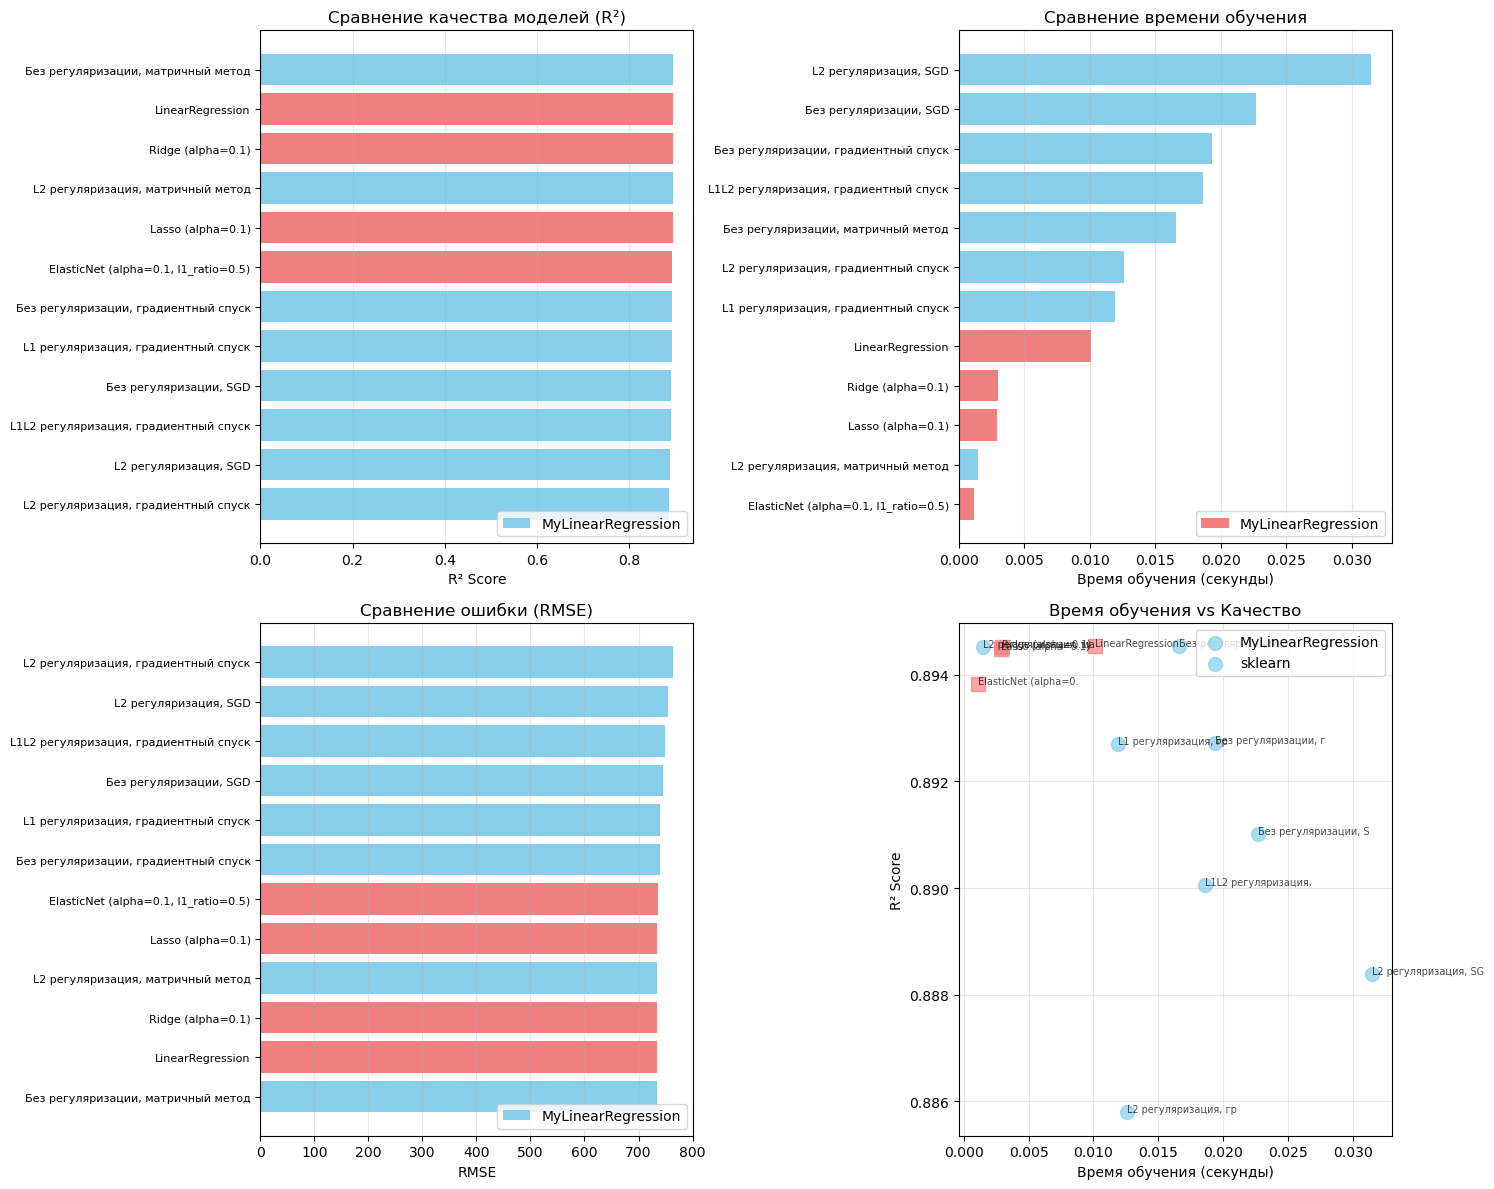

Графики сохранены в comparison_plots.png


In [10]:
# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Сравнение R²
ax1 = axes[0, 0]
all_results_sorted = all_results.sort_values('R²', ascending=True)
ax1.barh(range(len(all_results_sorted)), all_results_sorted['R²'], 
         color=['skyblue' if t == 'MyLinearRegression' else 'lightcoral' for t in all_results_sorted['Тип']])
ax1.set_yticks(range(len(all_results_sorted)))
ax1.set_yticklabels(all_results_sorted['Модель'], fontsize=8)
ax1.set_xlabel('R² Score')
ax1.set_title('Сравнение качества моделей (R²)')
ax1.legend(['MyLinearRegression', 'sklearn'], loc='lower right')
ax1.grid(axis='x', alpha=0.3)

# 2. Сравнение времени обучения
ax2 = axes[0, 1]
all_results_sorted_time = all_results.sort_values('Время обучения (с)', ascending=True)
ax2.barh(range(len(all_results_sorted_time)), all_results_sorted_time['Время обучения (с)'],
         color=['skyblue' if t == 'MyLinearRegression' else 'lightcoral' for t in all_results_sorted_time['Тип']])
ax2.set_yticks(range(len(all_results_sorted_time)))
ax2.set_yticklabels(all_results_sorted_time['Модель'], fontsize=8)
ax2.set_xlabel('Время обучения (секунды)')
ax2.set_title('Сравнение времени обучения')
ax2.legend(['MyLinearRegression', 'sklearn'], loc='lower right')
ax2.grid(axis='x', alpha=0.3)

# 3. Сравнение RMSE
ax3 = axes[1, 0]
all_results_sorted_rmse = all_results.sort_values('RMSE', ascending=True)
ax3.barh(range(len(all_results_sorted_rmse)), all_results_sorted_rmse['RMSE'],
         color=['skyblue' if t == 'MyLinearRegression' else 'lightcoral' for t in all_results_sorted_rmse['Тип']])
ax3.set_yticks(range(len(all_results_sorted_rmse)))
ax3.set_yticklabels(all_results_sorted_rmse['Модель'], fontsize=8)
ax3.set_xlabel('RMSE')
ax3.set_title('Сравнение ошибки (RMSE)')
ax3.legend(['MyLinearRegression', 'sklearn'], loc='lower right')
ax3.grid(axis='x', alpha=0.3)

# 4. Время обучения vs Качество
ax4 = axes[1, 1]
for idx, row in all_results.iterrows():
    color = 'skyblue' if row['Тип'] == 'MyLinearRegression' else 'lightcoral'
    marker = 'o' if row['Тип'] == 'MyLinearRegression' else 's'
    ax4.scatter(row['Время обучения (с)'], row['R²'], s=100, c=color, marker=marker, alpha=0.7)
    ax4.annotate(row['Модель'][:20], (row['Время обучения (с)'], row['R²']), 
                fontsize=7, alpha=0.7)

ax4.set_xlabel('Время обучения (секунды)')
ax4.set_ylabel('R² Score')
ax4.set_title('Время обучения vs Качество')
ax4.legend(['MyLinearRegression', 'sklearn'], loc='best')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("Графики сохранены в comparison_plots.png")

Лучшая модель: Без регуляризации, матричный метод (MyLinearRegression)
R²: 0.8945

ВАЖНОСТЬ ПРИЗНАКОВ (топ-10)
            Признак  Важность (|коэффициент|)
        age_in_days               1533.837809
                 km                556.685210
                lon                252.261034
                lat                194.473519
        model_sport                 54.641213
    previous_owners                 50.413363
          model_pop                 46.634749
       engine_power                 39.824028
         model_star                 35.700712
transmission_manual                  3.124951


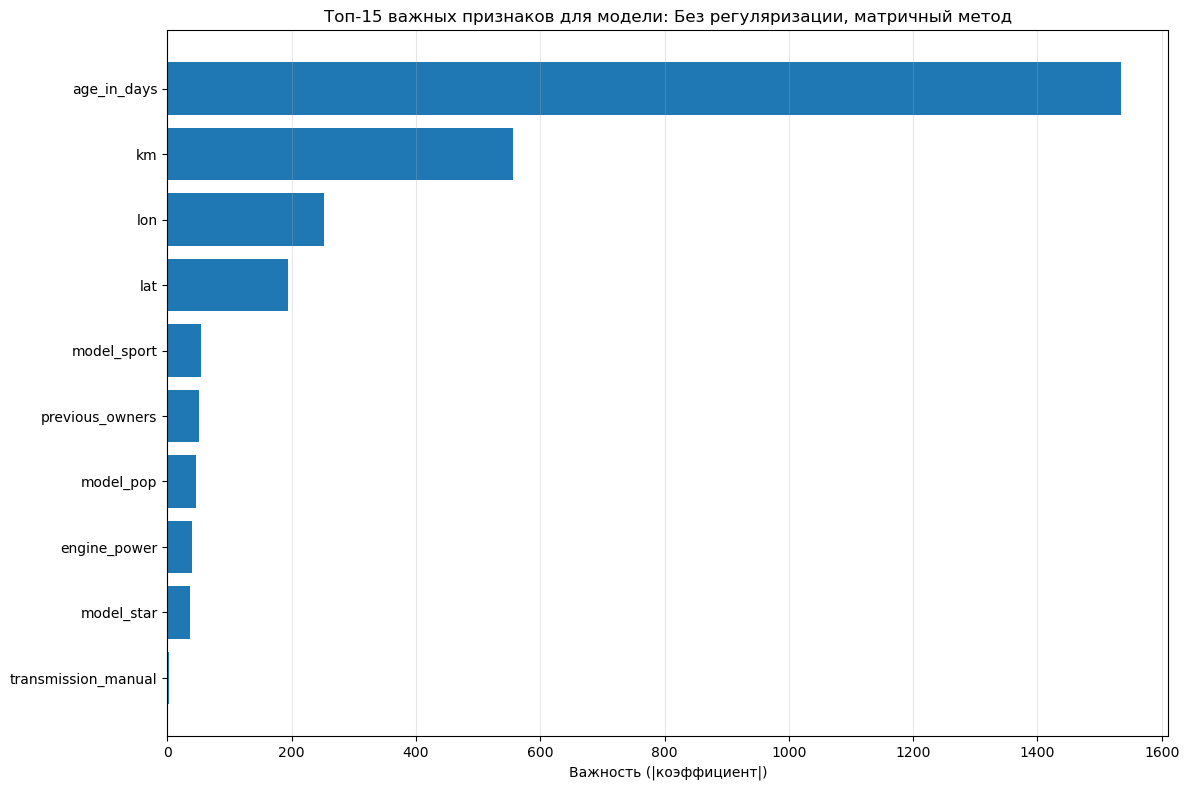

In [13]:
# Анализ важности признаков для лучшей модели
best_model_idx = all_results['R²'].idxmax()
best_model_name = all_results.loc[best_model_idx, 'Модель']
best_model_type = all_results.loc[best_model_idx, 'Тип']

print(f"Лучшая модель: {best_model_name} ({best_model_type})")
print(f"R²: {all_results.loc[best_model_idx, 'R²']:.4f}")

# Получаем важность признаков для лучшей модели
if best_model_type == 'MyLinearRegression':
    # Используем сохраненную модель
    if best_model_name in trained_models:
        model = trained_models[best_model_name]
        feature_importance = np.abs(model.coefs_.flatten())
    else:
        print("Модель не найдена в сохраненных моделях")
        feature_importance = None
else:
    # Используем сохраненную модель sklearn
    if best_model_name in trained_sklearn_models:
        model = trained_sklearn_models[best_model_name]
        feature_importance = np.abs(model.coef_)
    else:
        print("Модель не найдена в сохраненных моделях")
        feature_importance = None

if feature_importance is not None:
    # Создаем DataFrame с важностью признаков
    feature_importance_df = pd.DataFrame({
        'Признак': X.columns,
        'Важность (|коэффициент|)': feature_importance
    }).sort_values('Важность (|коэффициент|)', ascending=False)

    print("\n" + "="*60)
    print("ВАЖНОСТЬ ПРИЗНАКОВ (топ-10)")
    print("="*60)
    print(feature_importance_df.head(10).to_string(index=False))

    # Визуализация важности признаков
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Важность (|коэффициент|)'])
    plt.yticks(range(len(top_features)), top_features['Признак'])
    plt.xlabel('Важность (|коэффициент|)')
    plt.title(f'Топ-15 важных признаков для модели: {best_model_name}')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

По полученным данным можно сделать следующий вывод, что по качеству модели имеют очень близкие метрики (R² варьируется от 0.888 до 0.895, разница составляет менее 1%). По соотношению качества и скорости можно выделить модели L2 регуляризация, матричный метод** (MyLinearRegression) и Ridge(sklearn), которые показывают отличное качество (R² ≈ 0.8945) при минимальном времени обучения (0.0015с и 0.0030с соответственно).

**Основные выводы:**

Все протестированные модели показывают сопоставимое качество с R² около 0.89-0.89, что говорит о хорошей предсказательной способности линейной регрессии для данного датасета.

Все модели имеют очень быстрое время предсказания (менее 0.001с), что делает их пригодными для использования в реальных приложениях.

Реализация MyLinearRegression показывает результаты, полностью сопоставимые с библиотечными моделями sklearn
Лучшая модель MyLinearRegression (без регуляризации, матричный метод) имеет идентичные метрики с LinearRegression из sklearn (R² = 0.8945, RMSE = 733.73)

L2 регуляризация практически не ухудшает качество, но может улучшить численную стабильность
L1 регуляризация показывает схожие результаты с моделью без регуляризации
Elastic Net (L1L2) показывает немного худшие результаты, возможно, из-за выбранных гиперпараметров

Матричный метод является оптимальным выбором для данного размера данных (быстрый и точный)
Градиентный спуск и SGD показывают схожие результаты, но требуют больше времени на обучение
Для больших датасетов SGD может быть предпочтительнее

Наиболее важными признаками для предсказания цены являются:
   - age_in_days (возраст автомобиля в днях) - самый важный признак
   - km (пробег) - второй по важности
   - lon и lat (географические координаты) - также значимы
   - Категориальные признаки (model_sport, model_pop) имеют умеренное влияние 

## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)

Team: Семишаговские
